### Importing Libraries

In [1]:
import urllib.request
import os, datetime, random, shutil, zipfile, warnings
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf, seaborn as sns
from tqdm import tqdm
from PIL import Image

# 🔹 Suppress ALL warnings globally
warnings.filterwarnings("ignore")

# 🔹 Mixed Precision
tf.keras.mixed_precision.set_global_policy('float32')

### Downloading dataset

In [2]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "catsdogs.zip"
urllib.request.urlretrieve(data_url, data_file_name)

('catsdogs.zip', <http.client.HTTPMessage at 0x30a6f9d80>)

### Downloading model weights

In [3]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x30a6f9f90>)

### Unzipping dataset

In [4]:
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
os.remove("./catsdogs.zip")
os.remove("./CDLA-Permissive-2.0.pdf")
os.remove("./readme[1].txt")

### Moving files for train-test split

In [6]:
def move_percentage(src_dir, dest_dir, percentage):
    os.makedirs(dest_dir, exist_ok=True)
    all_files = os.listdir(src_dir)
    num_files_to_move = int(len(all_files) * percentage/100)
    random.shuffle(all_files)

    for filename in tqdm(all_files[:num_files_to_move], desc=f"Moving {percentage}% of images"):
        if filename.endswith(".jpg"):
            src_path = os.path.join(src_dir, filename)
            dest_path = os.path.join(dest_dir, filename)
            shutil.move(src_path, dest_path)


dog_src_dir = "./PetImages/Dog"
dog_dest_dir = "./PetImages/test/dog"
move_percentage(dog_src_dir, dog_dest_dir, 20)

cat_src_dir = "./PetImages/Cat"
cat_dest_dir = "./PetImages/test/cat"
move_percentage(cat_src_dir, cat_dest_dir, 20)

Moving 20% of images: 100%|██████████| 2500/2500 [00:00<00:00, 10668.03it/s]


In [7]:
src_path = "./PetImages/Cat"
dest_path = "./PetImages/train"
os.makedirs(dest_path, exist_ok=True)
shutil.move(src_path, dest_path)

src_path = "./PetImages/Dog"
dest_path = "./PetImages/train"
os.makedirs(dest_path, exist_ok=True)
shutil.move(src_path, dest_path)

'./PetImages/train/Dog'

In [8]:
os.rename("./PetImages/train/Dog", "./PetImages/train/dog")
os.rename("./PetImages/train/Cat", "./PetImages/train/cat")

### Remove corrupted images

In [9]:
def remove_corrupted_images(directory):
    removed_files = 0
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Open the image to check if it's valid
                img = Image.open(file_path)
                img.verify()  # Verify file integrity
            except (IOError, SyntaxError):
                print(f"Corrupted file removed: {file_path}")
                os.remove(file_path)
                removed_files += 1
    print(f"\n✅ Total corrupted files removed: {removed_files}")

# Clean both train and test datasets
remove_corrupted_images("./PetImages/train")
remove_corrupted_images("./PetImages/test")

Corrupted file removed: ./PetImages/train/cat/Thumbs.db
Corrupted file removed: ./PetImages/train/cat/666.jpg
Corrupted file removed: ./PetImages/train/dog/Thumbs.db
Corrupted file removed: ./PetImages/train/dog/11702.jpg

✅ Total corrupted files removed: 4

✅ Total corrupted files removed: 0


### Dataset Pipeline

In [10]:
TRAINING_DIR = "./PetImages/train"
TEST_DIR = "./PetImages/test"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                                    brightness_range=[0.8, 1.2],
                                    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_dataset = train_datagen.flow_from_directory(TRAINING_DIR, target_size=(150, 150), batch_size=128, class_mode='binary', 
                                                  color_mode='rgb', shuffle=True)
test_dataset = test_datagen.flow_from_directory(TEST_DIR, target_size=(150, 150), batch_size=128, class_mode='binary', 
                                                color_mode='rgb', shuffle=False)
print(train_dataset.class_indices)


Found 19999 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.
{'cat': 0, 'dog': 1}


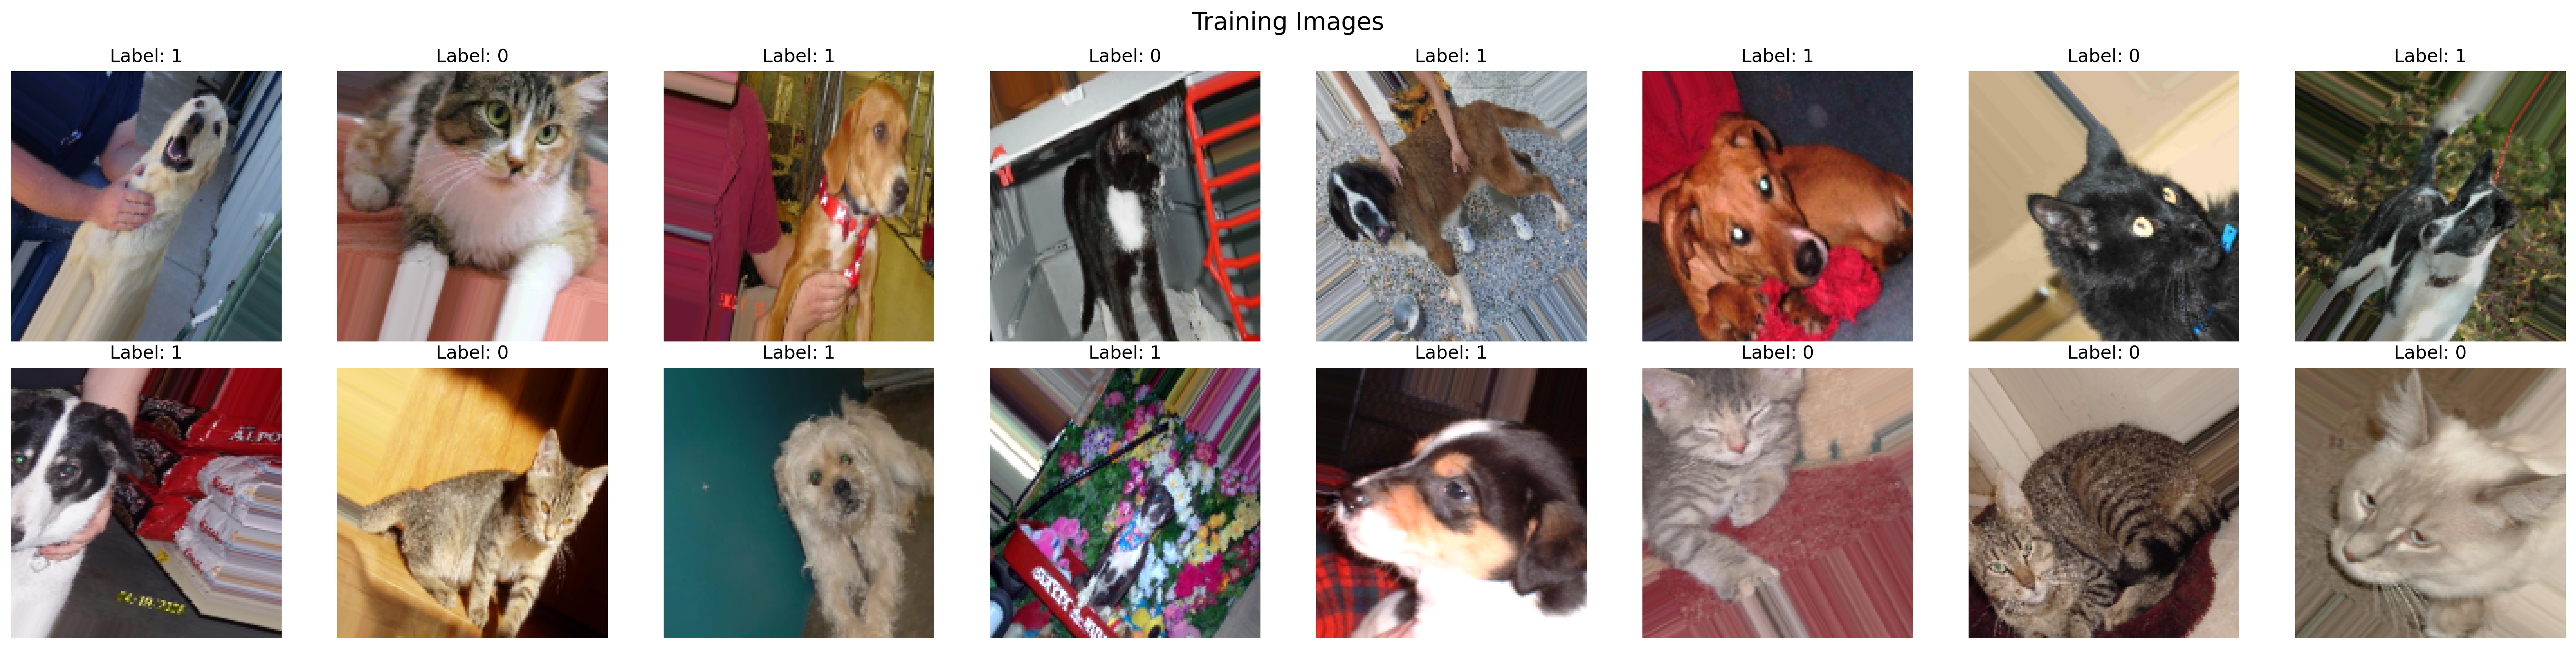

In [11]:
images, labels = next(train_dataset)

num_images = 16
cols=8; rows=num_images//cols

figure, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3), dpi=300)
for i in range(num_images):
    ax = axes[i//cols, i%cols]
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]:0.0f}")
    ax.axis('off')
plt.suptitle("Training Images", fontsize=16)
plt.tight_layout(); plt.show()

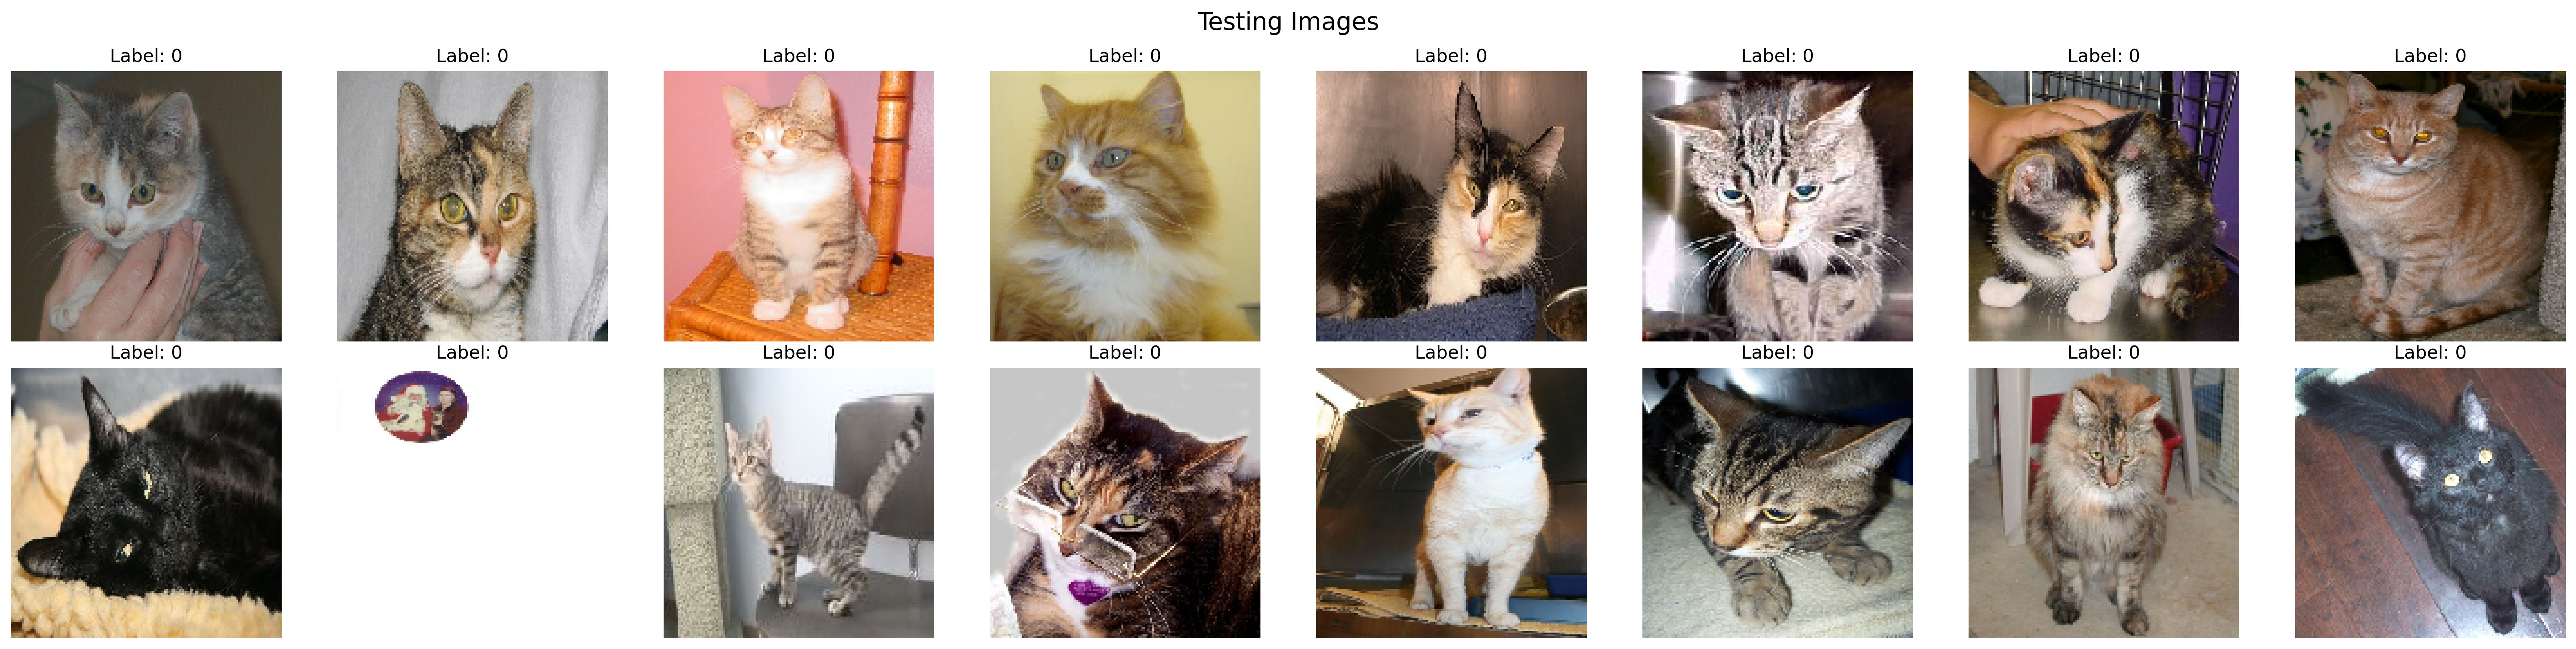

In [12]:
# Correct way to get one batch from a DirectoryIterator
images, labels = next(test_dataset)

num_images = 16
cols=8; rows=num_images//cols

figure, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3), dpi=300)
for i in range(num_images):
    ax = axes[i//cols, i%cols]
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]:0.0f}")
    ax.axis('off')
plt.suptitle("Testing Images", fontsize=16)
plt.tight_layout(); plt.show()

### Model Architecture
---

In [13]:
pre_trained_model = tf.keras.applications.InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights("./inception_v3.h5")
pre_trained_model.trainable = False
#pre_trained_model.summary()
output = pre_trained_model.output

x = tf.keras.layers.Flatten()(output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x, name="Classifier")
#model.summary()

2025-09-02 13:57:16.912285: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-09-02 13:57:16.912319: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-02 13:57:16.912325: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-02 13:57:16.912346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-02 13:57:16.912364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=1e-4, first_decay_steps=157, alpha=0.1)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=scheduler), loss='binary_crossentropy', metrics=['accuracy'])

### Training

In [15]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model.weights.h5', 
                                                save_best_only=True, save_weights_only=True, 
                                                monitor='val_loss', mode='min', verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)]

history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose=1, callbacks=callbacks)

Epoch 1/100


2025-09-02 13:57:28.320316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8726 - loss: 2.8625
Epoch 1: val_loss improved from None to 0.25117, saving model to best_model.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 461ms/step - accuracy: 0.9080 - loss: 1.1014 - val_accuracy: 0.9618 - val_loss: 0.2512
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9183 - loss: 0.4405
Epoch 2: val_loss improved from 0.25117 to 0.23603, saving model to best_model.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 429ms/step - accuracy: 0.9241 - loss: 0.3685 - val_accuracy: 0.9520 - val_loss: 0.2360
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9277 - loss: 0.2856
Epoch 3: val_loss improved from 0.23603 to 0.14632, saving model to best_model.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 70s 442ms/step - accuracy: 0.9271 - loss: 0.2679 - val_accuracy: 0.9626 - val_loss: 0.1463
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9205 - loss: 0.3085
Epoch 4: val_loss did not imp

### Plotting Training History

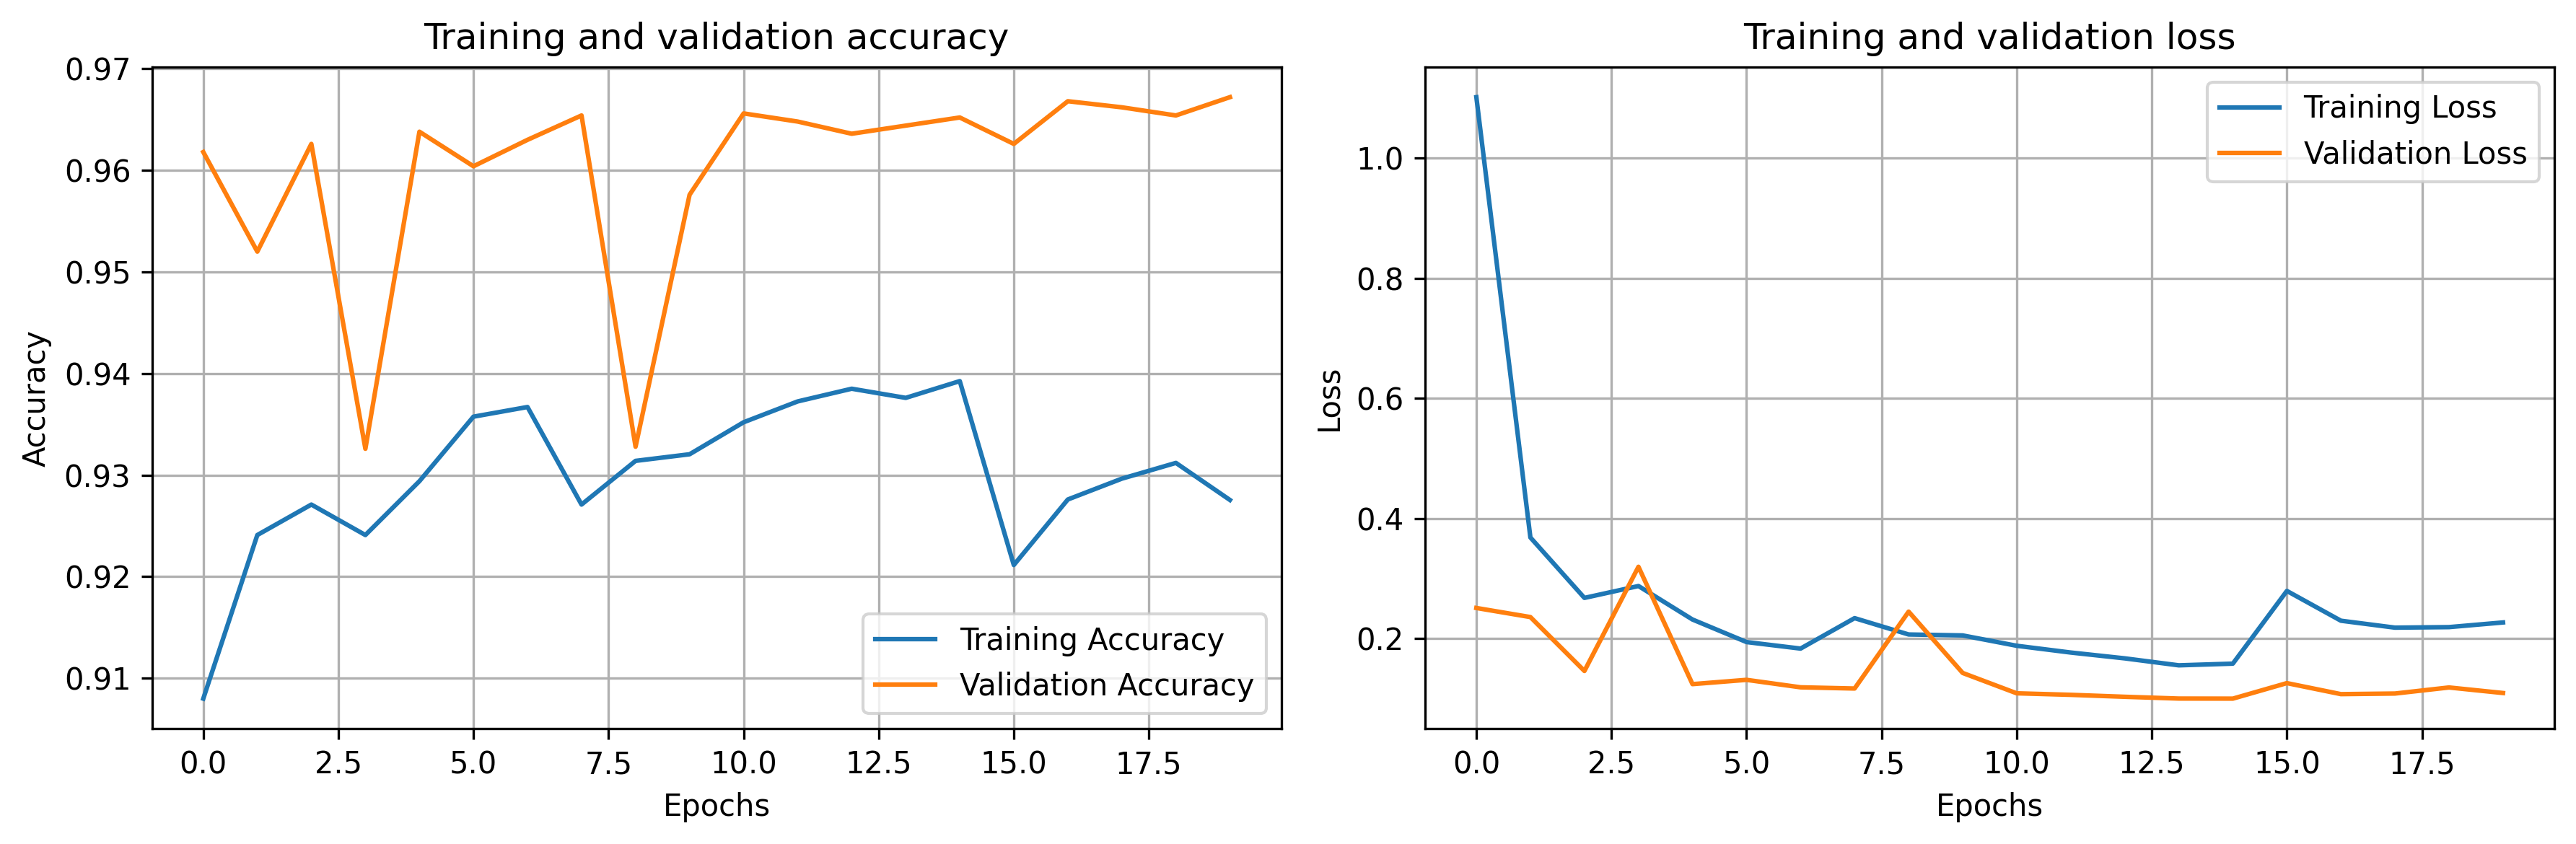

In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

figure = plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy"); plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title('Training and validation accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss"); plt.plot(epochs, val_loss, label="Validation Loss")
plt.title('Training and validation loss'); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid()

plt.tight_layout(); plt.show()

## Results
---

In [17]:
model.load_weights('best_model.weights.h5')

### Classification Report

In [18]:
predictions = model.predict(test_dataset, verbose=1)
y_pred = (predictions > 0.5).astype(int)
y_pred = np.squeeze(y_pred)
y_true = test_dataset.labels
class_labels = list(test_dataset.class_indices.keys())

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step


In [19]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("📊 Classification Report")
print("=======================")
print(report)

📊 Classification Report
              precision    recall  f1-score   support

         cat       0.97      0.96      0.97      2499
         dog       0.96      0.97      0.97      2500

    accuracy                           0.97      4999
   macro avg       0.97      0.97      0.97      4999
weighted avg       0.97      0.97      0.97      4999



### Confusion Matrix

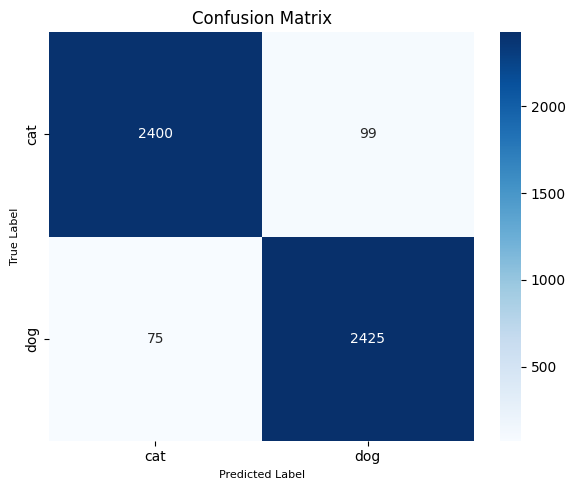

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5), dpi=100)
sns.heatmap(cm, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=12)
plt.xlabel('Predicted Label', fontsize=8)
plt.ylabel('True Label', fontsize=8)

plt.tight_layout()
plt.show()

### ROC curve & AUC score

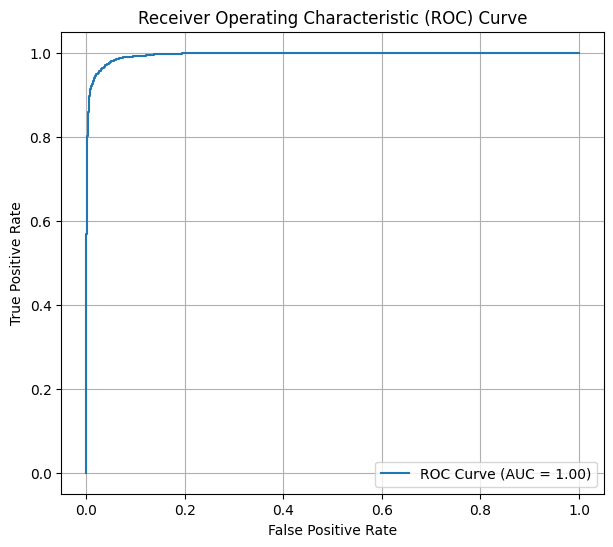

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Calculate the values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)

# 2. Calculate the AUC score
auc = roc_auc_score(y_true, predictions)

# 3. Plot the curve
plt.figure(figsize=(7, 6), dpi=100)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
#plt.plot([0, 1], [0, 1], 'r--', label='Random Guess') # Dashed line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

### Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


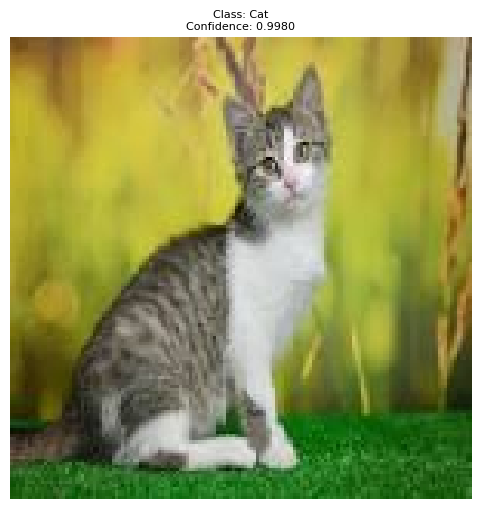

In [22]:
from tensorflow.keras.utils import load_img, img_to_array

path = "./test_imgs/cat3.jpg"
img = load_img(path, target_size=(150, 150))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
classification = model.predict(img_array)
if classification[0][0]>0.5:
    cls = "Dog"
    confidence = classification[0][0]
else:
    cls = "Cat"
    confidence = 1 - classification[0][0]

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(img)
plt.axis('off')
plt.title(f"Class: {cls}\nConfidence: {confidence:.4f}", fontsize=8)
plt.show()
